In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch

In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

from pts.modules import StudentTOutput

from ConvTSMixer import ConvTSMixerEstimator

In [3]:
dataset = get_dataset("solar_nips", regenerate=False)
train_grouper = MultivariateGrouper(max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

In [4]:
estimator = ConvTSMixerEstimator(
    #distr_output=StudentTOutput(dim=int(dataset.metadata.feat_static_cat[0].cardinality)),
    input_size=int(dataset.metadata.feat_static_cat[0].cardinality),
    
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    scaling="std",
        
    batch_size=128,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(accelerator="cpu")
)

In [ ]:
predictor = estimator.train(
    training_data=dataset_train, 
    cache_data=True, 
    shuffle_buffer_length=1024, 
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/opt/homebrew/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
/opt/homebrew/lib/python3.10/site-packages/pytorch_lightning/trai

Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached 4.80454 (best 4.80454), saving model to '/Users/kashif/Github/ConvTS-Mixer/lightning_logs/version_32/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached 4.48590 (best 4.48590), saving model to '/Users/kashif/Github/ConvTS-Mixer/lightning_logs/version_32/checkpoints/epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached 4.37081 (best 4.37081), saving model to '/Users/kashif/Github/ConvTS-Mixer/lightning_logs/version_32/checkpoints/epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' reached 4.32437 (best 4.32437), saving model to '/Users/kashif/Github/ConvTS-Mixer/lightning_logs/version_32/checkpoints/epoch=3-step=400.ckpt' as top 1
Epoch 4, global step 500: 'train_loss' reached 4.29615 (best 4.29615), saving model to '/Users/kashif/Github/ConvTS-Mixer/lightning_logs/version_32/checkpoints/epoch=4-step=500.ckpt' as top 1
Epoch 5, global step 600: 'train_loss' r

In [18]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

In [19]:
forecasts = list(forecast_it)

In [11]:
tss = list(ts_it)

In [20]:
evaluator = Evaluator()

In [21]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))


Running evaluation: 959it [00:00, 9311.68it/s]


In [22]:
agg_metrics

{'MSE': 2869.796667718871,
 'abs_error': 613406.1799583435,
 'abs_target_sum': 708873.5020904541,
 'abs_target_mean': 30.799161543728452,
 'seasonal_error': 13.175128459742648,
 'MASE': 2.0356642530838682,
 'MAPE': 1.6555618667346141,
 'sMAPE': 1.634893085876189,
 'MSIS': 17.80141589771897,
 'QuantileLoss[0.1]': 287510.0943669945,
 'Coverage[0.1]': 0.04331769204031977,
 'QuantileLoss[0.2]': 433052.6259015858,
 'Coverage[0.2]': 0.2882777198470629,
 'QuantileLoss[0.3]': 534390.990673562,
 'Coverage[0.3]': 0.4057177615571776,
 'QuantileLoss[0.4]': 593317.6743383855,
 'Coverage[0.4]': 0.4973496697949253,
 'QuantileLoss[0.5]': 613406.180105634,
 'Coverage[0.5]': 0.591762252346194,
 'QuantileLoss[0.6]': 599666.3269080638,
 'Coverage[0.6]': 0.6538060479666319,
 'QuantileLoss[0.7]': 554763.9352277517,
 'Coverage[0.7]': 0.7082464372610358,
 'QuantileLoss[0.8]': 459977.59889502526,
 'Coverage[0.8]': 0.7765033020507474,
 'QuantileLoss[0.9]': 301066.26522440906,
 'Coverage[0.9]': 0.876911713590545

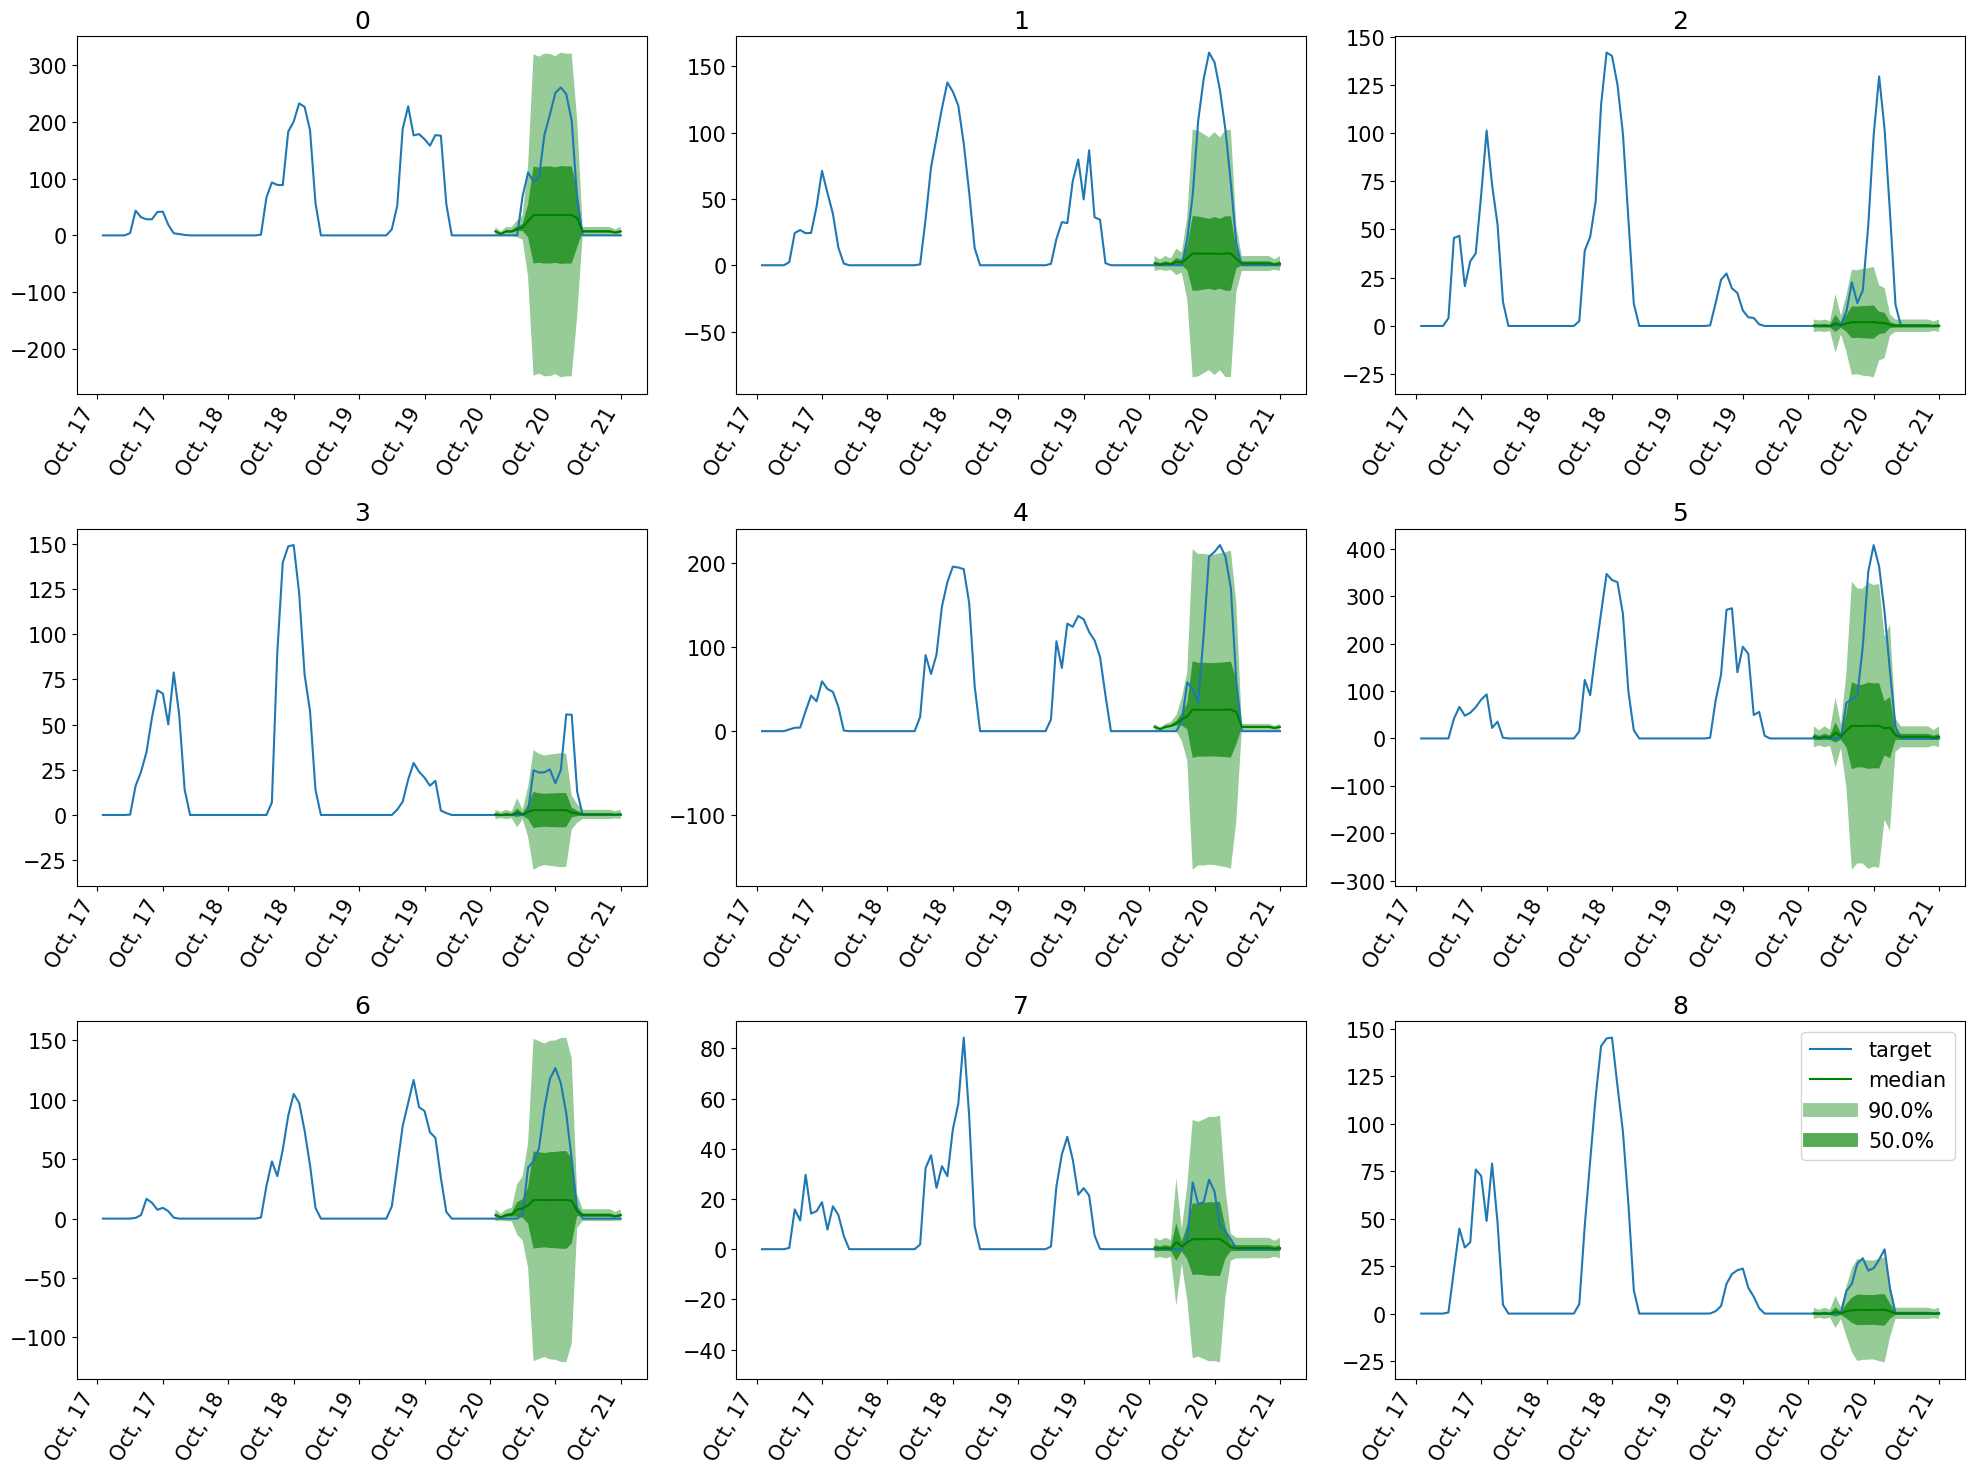

In [23]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()